# Example of outputting results of mvpolyfit to python code

In [154]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Import libs
from positive import *
from matplotlib.pyplot import *
from numpy import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create a fiducial mvpolyfit object. Call it "foo".

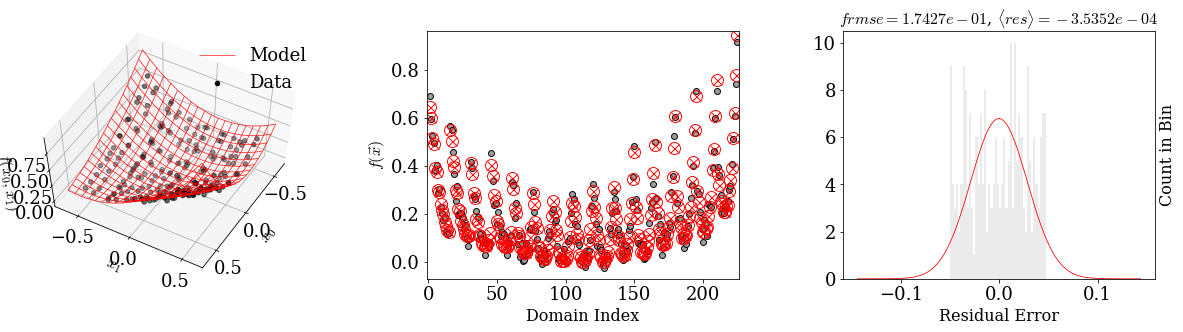

In [155]:
x0 = linspace(-0.5,0.5,15)
y0 = array(x0)
u0 = array(x0)

# Set random seed so that we always get the same answers
random.seed( 30 )

x = x0 + 0.08*(random.random( x0.shape )-0.5)
y = y0 + 0.08*(random.random( y0.shape )-0.5)
X,Y = meshgrid(x,y)
zfun = lambda xx,yy: xx**2 + yy**2 + xx*yy + yy*xx**2

Z = zfun(X,Y) + 0.1*(random.random( X.shape )-0.5)

#
domain,scalar_range = ndflatten( [X,Y], Z )

foo = mvpolyfit( domain, scalar_range, basis_symbols=['00','11','01','100'], verbose = True );
foo.plot();



### We've printed the resulting fit function in various forms below

In [156]:
alert('Python String',header=True)
print yellow('* IMPORTANT -- make sure that the precision input is consistent with the number of significant figures for your model\n')
print foo.__str_python__(precision=5)
alert('Latex String',header=True)
print yellow('* It can be useful for latex versions to be less precise\n')
print foo.__str_latex__(precision=2).replace(r'\\ \nonumber','').replace('\n','').replace(r'\quad','').replace(r'&','')


# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(notebook)>> Python String
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

* IMPORTANT -- make sure that the precision input is consistent with the number of significant figures for your model

f = lambda x0,x1: 9.91444e-01*(x1*x1) + 9.93282e-01*(x0*x0) + 9.96038e-01*(x0*x1) + 1.03054e+00*(x1*x0*x0)

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(notebook)>> Latex String
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

* It can be useful for latex versions to be less precise

f(\vec{x})  \; = \;  9.91e-01\,{x1}^{2} \; + \; (9.93e-01)\,{x0}^{2}      \; + \; (9.96e-01)\,x0\,x1 \; + \; (1.03e+00)\,x1\,{x0}^{2}


\begin{align}
f(\vec{x})  \; = \;  1.02e+00\,{x1}^{2} \; + \; (9.78e-01)\,{x0}^{2}      \; + \; (9.80e-01)\,x0\,x1 \; + \; (9.27e-01)\,x1\,{x0}^{2}
\end{align}

### Note that the springs can be hacked for other purposes. For example, below I use the python string to construct a C function string.

In [157]:
pystr = foo.__str_python__(precision=8)
# Only take the useful bits of this string
cstr = pystr.split(':')[-1]
print cyan('This will be added to C code: '),cstr

This will be added to C code:   9.91443548e-01*(x1*x1) + 9.93282096e-01*(x0*x0) + 9.96038493e-01*(x0*x1) + 1.03053717e+00*(x1*x0*x0)


In [158]:
C_template = r'''
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

// function prototype, also called function declaration
float myfunction ( float x0, float x1 );    

// main function, program starts from here
int main( int argc, char** argv )               
{
    // function call
    float x0 = atof(argv[1]);
    float x1 = atof(argv[2]);
    float ans = myfunction ( x0,x1 ) ;
    printf ( "humboldt penguin says: %1.13f\n",ans );
}

float myfunction ( float x0, float x1 )   // function definition
{
    float p ;
    p = *MYCODE* ;
    return ( p ) ;
}
'''

### Put the fit function in the C Code

In [159]:
C_code = C_template.replace(r'*MYCODE*',cstr)

### Write the code to a file

In [160]:
from os.path import expanduser
fo = open(expanduser('~/Desktop/humboldt_penguin.c'),"w") 
fo.write(C_code)
fo.close()

### Compile the C code and comare its output to the python code

Compile the code with:

```bash
gcc -o ~/Desktop/foo ~/Desktop/humboldt_penguin.c
```

Evalue the code with x0=1.1 and x1 = 3.14:

```bash
~/Desktop/foo 1.1 3.14
```

In [161]:
%%bash
# Compile
gcc -o ~/Desktop/foo ~/Desktop/humboldt_penguin.c
# Run with sample inputs
~/Desktop/foo 0.25 -0.4

humboldt penguin says: 0.0953438282013


#### Evaluate the python model with the same inputs

In [162]:
pyvalue = foo.eval( array([ [0.25], [-0.4] ]).T )[0]
print 'another humboldt penguin says: ',pyvalue

another humboldt penguin says:  0.09534382004989973


In [163]:
cvalue = 0.0953438282013

In [164]:
print 'pyvalue-cvalue = ',pyvalue-cvalue
alert(yellow('This should be tiny!'))

pyvalue-cvalue =  -8.15140026311223e-09
(notebook)>> This should be tiny!


In [165]:
%%bash 
# Clean up example files
rm ~/Desktop/foo ~/Desktop/humboldt_penguin.c